In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation, Add, Dropout
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
import tensorflow.keras.backend as K
import gc
from keras import optimizers
from tqdm.notebook import tqdm_notebook

In [3]:
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.4.0


In [4]:
'''----------LOAD DATA----------------'''

data_dir = "../DL_data/competition_data"

nrows = "all"                 # Set to 'all' to load the whole set
load_validation = False      # Only load the validation images and masks


#load the ids  and depths of 'nrows' from the training data set
if isinstance(nrows, int) and nrows>0:
    train_df = pd.read_csv(data_dir+"/train.csv", index_col="id", usecols=[0], nrows=nrows)
    depths_df = pd.read_csv(data_dir+"/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
elif isinstance(nrows, str) and nrows.upper() == "ALL":
    train_df = pd.read_csv(data_dir+"/train.csv", index_col="id", usecols=[0])
    depths_df = pd.read_csv(data_dir+"/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
else:
    raise ValueError("Invalid nrows value")
        

        
# Function that loads the ids of 'nrows' from the validation data set
def load_validation_data(data_dir, nrows):
    if isinstance(nrows, int) and nrows>0:
        valid_ids = pd.read_csv(data_dir+"/Validation_ids.csv", usecols=[1], nrows=nrows)
    elif isinstance(nrows, str) and nrows.upper() == "ALL":
        valid_ids = pd.read_csv(data_dir+"/Validation_ids.csv")
    else:
        raise ValueError("Invalid nrows value")
    return valid_ids.ids

In [5]:
if load_validation:
    ids_to_load = load_validation_data(data_dir, nrows)
    index_list = list(train_df.index)
    ids_list = [index_list.index(i) for i in ids_to_load]
    train_df = train_df.iloc[ids_list]
else:
    ids_to_load = train_df.index
    
print("Loading images...")
train_df["images"] = [np.array(load_img(data_dir+"/train/images/{}.png".format(idx),
                                        color_mode = "grayscale"))/255 for idx in tqdm_notebook(list(ids_to_load))]
print("Loading masks...")
train_df["masks"] = [np.array(load_img(data_dir+"/train/masks/{}.png".format(idx),
                                       color_mode = "grayscale"))/65535 for idx in tqdm_notebook(list(ids_to_load))] 
 #train_df.index

print("done loading images")

Loading images...


  0%|          | 0/4000 [00:00<?, ?it/s]

Loading masks...


  0%|          | 0/4000 [00:00<?, ?it/s]

done loading images


In [6]:
print(train_df)

              z                                             images  \
id                                                                   
2c45b152f1  312  [[0.3411764705882353, 0.3568627450980392, 0.37...   
3cb59a4fdc  603  [[0.45098039215686275, 0.5411764705882353, 0.5...   
e185ab5dc1  687  [[0.4666666666666667, 0.5058823529411764, 0.54...   
c78c89577c  236  [[0.3411764705882353, 0.3176470588235294, 0.32...   
6306dd3a8e  805  [[0.5490196078431373, 0.5568627450980392, 0.56...   
...         ...                                                ...   
429b289e07  562  [[0.5137254901960784, 0.5215686274509804, 0.52...   
5d752d6d4a  235  [[0.4392156862745098, 0.4392156862745098, 0.43...   
26527458de  587  [[0.5490196078431373, 0.5647058823529412, 0.58...   
25fb3a895a  468  [[0.20392156862745098, 0.26666666666666666, 0....   
f30c36bf6b  324  [[0.44313725490196076, 0.4392156862745098, 0.4...   

                                                        masks  
id                       

In [7]:
# -------------> data example
# printing
print("-------------------------------------------------------------")
id = '2a070f3dc6'
id_index = np.where(train_df.index == id)
id_index = id_index[0][0]
print("id_index = ", id_index)
image = train_df["images"][id]
print(image)
print(image.shape)
print("-------------------------------------------------------------")
mask = train_df["masks"][id]
print(mask)
print(mask.shape)

-------------------------------------------------------------
id_index =  202
[[0.36078431 0.36078431 0.36862745 ... 0.19607843 0.23529412 0.26666667]
 [0.36078431 0.36470588 0.37647059 ... 0.25490196 0.2745098  0.2745098 ]
 [0.36078431 0.37254902 0.38039216 ... 0.31372549 0.29803922 0.27843137]
 ...
 [0.36470588 0.37254902 0.38039216 ... 0.4        0.39607843 0.39215686]
 [0.36862745 0.37647059 0.38039216 ... 0.39607843 0.39607843 0.39215686]
 [0.37254902 0.38039216 0.38039216 ... 0.39607843 0.39607843 0.39607843]]
(101, 101)
-------------------------------------------------------------
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(101, 101)


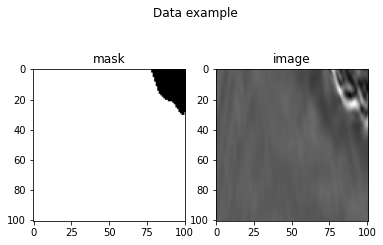

In [8]:
def plot_image_example():
    fig_imgshow, (axs_mask, axs_img) = plt.subplots(1, 2)
    fig_imgshow.suptitle("Data example")
    axs_img.imshow(np.dstack((image, image, image)))  # interpolation='nearest'
    axs_img.set(title="image")
    tmp = np.squeeze(mask).astype(np.float32)
    axs_mask.imshow(np.dstack((tmp, tmp, tmp)))
    axs_mask.set(title="mask")


plot_image_example()

# **Prepossessing Data**

#### ------> Resize to a pow of 2

In [9]:
# either pad with zeros or resize with interpolation
resize_to = 101
original_size = 101


def upsample(original_img):
    if resize_to == original_size:
        return original_img
    return resize(original_img, (resize_to, resize_to), mode='constant', preserve_range=True)


def pad_zeros(array):
    padded_image = np.zeros(shape=(resize_to, resize_to))
    padded_image[13:114, 13:114] = array
    return padded_image

In [10]:
resizing_function_to_use = upsample

images_resized = np.array(train_df.images.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))
masks_resized = np.array(train_df.masks.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))

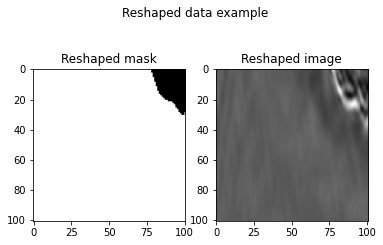

In [11]:
# Plotting
def plot_reshape_example():
    fig_reshape, (axs_reshape_mask, axs_reshape_img) = plt.subplots(1, 2)
    fig_reshape.suptitle("Reshaped data example")
    axs_reshape_img.set(title="Reshaped image")
    axs_reshape_mask.set(title="Reshaped mask")
    axs_reshape_img.imshow(images_resized[id_index], cmap='gray')
    axs_reshape_mask.imshow(masks_resized[id_index], cmap='gray')


plot_reshape_example()

#### -----> Calculating the salt coverage

In [12]:
train_df["coverage"] = train_df.masks.map(np.sum) / (train_df["masks"][0].shape[0]*train_df["masks"][0].shape[1])

# Generate salt coverage classes
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Plotting the salt coverage classes

Text(0.5, 0, 'Coverage class')

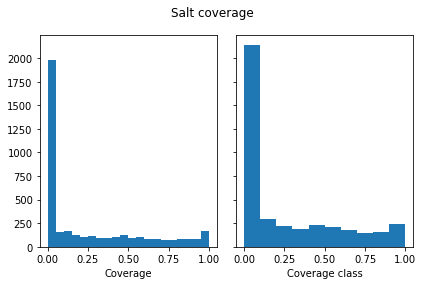

In [13]:
#TO_DO: Change that to use matplotlib
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
axs[0].hist(train_df.coverage, bins=n_bins)
axs[1].hist(train_df.coverage, bins=10)

plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

#### ------> Split train/dev

In [14]:
(ids_train, ids_valid,
x_train, x_valid,
y_train, y_valid,
cov_train, cov_test,
#depth_train, depth_test
 ) = train_test_split(
    train_df.index.values,
    images_resized,
    masks_resized,
    train_df.coverage.values,
    # train_df.z.values,
    test_size=0.1,
    stratify=train_df.coverage_class,
    random_state=1337)

print("Train/ Valid shape = %d/ %d"%(x_train.shape[0], x_valid.shape[0]))

Train/ Valid shape = 3600/ 400


In [ ]:
#print(ids_valid.shape)
#ids = {"ids": list(ids_valid)}
#df = pd.DataFrame(ids) # .to_csv("../DL_data/competition_data/Validation_ids.csv")
#df.to_csv("../DL_data/competition_data/Validation_ids.csv")

#### ------> Data augmentation

In [15]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [16]:
print("x_rain shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_rain shape:  (7200, 101, 101, 1)
y_train shape:  (7200, 101, 101, 1)


# U-Net

#### ------> Additional blocks

In [17]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

#### -----> IoU metric

In [18]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    #print("A shape: ", A.shape)
    #print("B shape: ", B.shape)
    metric = 0.0
    for batch in range(batch_size):
        
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        #print("True: ", t)
        #print("Predicted: ", p)
        #print("----------------------")
        #print("True sum: ", true)
        #print("Predicted sum: ", pred)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # Scale the iou function: iou -> 2*iou - 0.9
        # This will map the threshold values [0.5, 0.55, 0.6, ...., 0.9] to the
        # values [0.1, 0.2, 0.3, ....., 0.9]. Then multiply 2*iou - 0.9 by 10 and floor.
        # This will map the iou values to the number of thresholds that the iou sutisfies
        # witch is what we are intreasted in in the first playse.
        # For example if iou=0.552 then floor(2*iou - 0.9)*10 = 2. Since
        # eveery value <0 means an original value<0.5 we take the max with 0. Finaly we 
        # devide by 10 = |threshods|.
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

##### -----> Model definition

In [19]:
start_neurons = 16
DropoutRatio = 0.5
print("START BUILDING MODEL")
input_layer = Input((101, 101, 1))
print("BUILD INPUT")

# 101 -> 50
conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
conv1 = residual_block(conv1,start_neurons * 1)
conv1 = residual_block(conv1,start_neurons * 1, True)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(DropoutRatio/2)(pool1)

# 50 -> 25
conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
conv2 = residual_block(conv2,start_neurons * 2)
conv2 = residual_block(conv2,start_neurons * 2, True)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(DropoutRatio)(pool2)

# 25 -> 12
conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
conv3 = residual_block(conv3,start_neurons * 4)
conv3 = residual_block(conv3,start_neurons * 4, True)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(DropoutRatio)(pool3)

# 12 -> 6
conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
conv4 = residual_block(conv4,start_neurons * 8)
conv4 = residual_block(conv4,start_neurons * 8, True)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(DropoutRatio)(pool4)

# Middle
convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
convm = residual_block(convm,start_neurons * 16)
convm = residual_block(convm,start_neurons * 16, True)
    
# 6 -> 12
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(DropoutRatio)(uconv4)
    
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = residual_block(uconv4,start_neurons * 8)
uconv4 = residual_block(uconv4,start_neurons * 8, True)

# 12 -> 25
#deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
uconv3 = concatenate([deconv3, conv3])    
uconv3 = Dropout(DropoutRatio)(uconv3)
    
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = residual_block(uconv3,start_neurons * 4)
uconv3 = residual_block(uconv3,start_neurons * 4, True)

# 25 -> 50
deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
        
uconv2 = Dropout(DropoutRatio)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = residual_block(uconv2,start_neurons * 2)
uconv2 = residual_block(uconv2,start_neurons * 2, True)

# 50 -> 101
#deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
uconv1 = concatenate([deconv1, conv1])
    
uconv1 = Dropout(DropoutRatio)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = residual_block(uconv1,start_neurons * 1)
uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
#uconv1 = Dropout(DropoutRatio/2)(uconv1)
#output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
output_layer =  Activation('sigmoid')(output_layer_noActi)

START BUILDING MODEL
BUILD INPUT


In [20]:
model = Model(inputs=[input_layer], outputs=[output_layer])
print("BUILD MODEL")
adam_optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[my_iou_metric])
print("COMPILE")
model.summary()

BUILD MODEL
COMPILE
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 101, 101, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 101, 101, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 101, 101, 16) 0           batch_normalization[0][0]        
__________________________________________________________________________

#### -----> Training

In [21]:
epochs = 10
batch_len = 32
history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_len)

Epoch 1/10
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
225/225 [==============================] - 164s 603ms/step - loss: 0.4324 - my_iou_metric: 0.3448
Epoch 2/10
225/225 [==============================] - 136s 604ms/step - loss: 0.2977 - my_iou_metric: 0.5271
Epoch 3/10
225/225 [==============================] - 136s 605ms/step - loss: 0.2732 - my_iou_metric: 0.5364


#### Plotting model results and cleaning up

In [22]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        print(len(hs[label].history['loss']))
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        # plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()
    
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


10


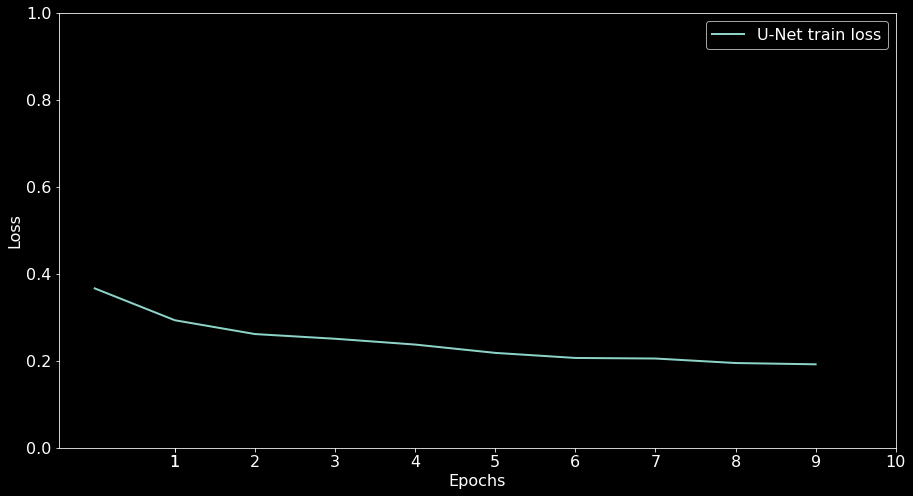


10


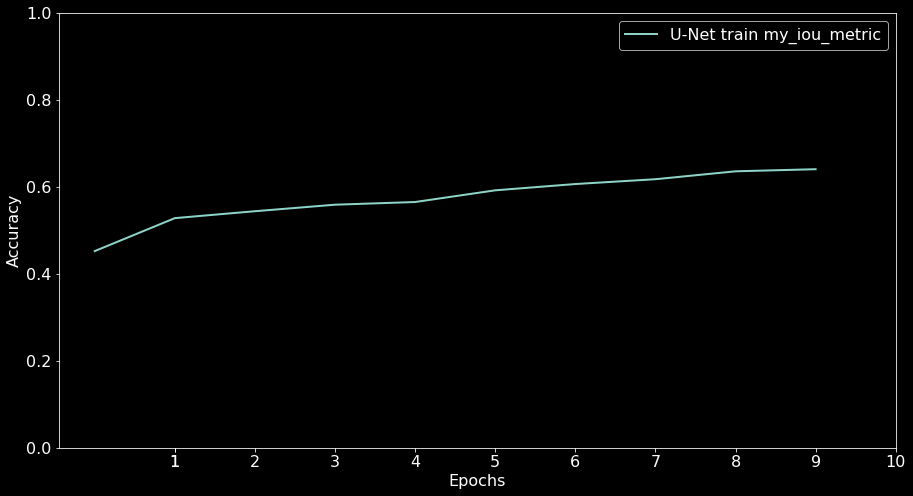

In [23]:
plot_history(hs={'U-Net': history}, epochs=epochs, metric='loss')
plot_history(hs={'U-Net': history}, epochs=epochs, metric='my_iou_metric')

In [ ]:
clean_up(model)